# Facial Keypoints Detection

This notebook explores initial data augmentation techniques. The kaggle train dataset is split into 2, one with 4 keypoints and other with 11 keypoints. Also using the split datasets train the initial models explored from the classical and popular models like LeNet, AlexNet, VGG-16.


In [1]:
import pandas as pd
import numpy as np
import sys, os, re, time, warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from scipy.ndimage import gaussian_filter
from math import sin,cos,pi
from skimage import exposure
from matplotlib import pyplot as plt
%matplotlib inline

# Set seed
np.random.seed(533)

In [2]:
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
from tensorflow import keras as keras
from keras import models, callbacks
from keras import Sequential, Model
from keras import optimizers, metrics
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import utils
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Concatenate
from keras.layers import Embedding

#tf.test.gpu_device_name()
print("tensorflow version {}".format(tf.__version__))
print("keras version {}".format(keras.__version__))

Using TensorFlow backend.


tensorflow version 2.1.0
keras version 2.2.4-tf


### Kaggle Setup 

In [3]:
#Set some directories.
train_zip_path = '/kaggle/input/facial-keypoints-detection/training.zip'
test_zip_path = '/kaggle/input/facial-keypoints-detection/test.zip'
Id_table_path = '/kaggle/input/facial-keypoints-detection/IdLookupTable.csv'
sample_sub_path = '/kaggle/input/facial-keypoints-detection/SampleSubmission.csv'
extracted_files_path = '/kaggle/working'

In [4]:
#Unzip train csv file to 'extracted_files_path'.
import zipfile
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)
#Unzip test csv file to 'extracted_files_path'.
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)

In [5]:
# train and test datasets file paths
FTRAIN = extracted_files_path + '/training.csv'
FTEST = extracted_files_path + '/test.csv'
FLOOKUP = Id_table_path

In [6]:
# Load the Kaggle data
print("Loading dataset..")
train = pd.read_csv(FTRAIN)
test = pd.read_csv(FTEST)
lookup = pd.read_csv(FLOOKUP)

Loading dataset..


### Other Env. Setup

Execute the steps for other environments.

In [3]:
# Input data file paths
FTRAIN = '../../data/training/training.csv'
FTEST = '../../data/test/test.csv'
FLOOKUP = '../../data/IdLookupTable.csv'

In [3]:
# Floyd Hub
# Input data file paths
FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

In [4]:
# Load the Kaggle data
print("Loading dataset..")
train = pd.read_csv(os.path.expanduser(FTRAIN))
test = pd.read_csv(os.path.expanduser(FTEST))
# Load the lookup file
lookup = pd.read_csv(os.path.expanduser(FLOOKUP))

Loading dataset..


### Helper functions


In [5]:
# Function to load the dataset into numpy arrays
def load_dataset(test = False, drop_bad_data = True):
    
    filename = FTEST if test else FTRAIN
    
    print("Loading Data...")
    
    # Read the data into a pandas dataframe
    df = pd.read_csv(os.path.expanduser(filename))

    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if not test:
        # Apply only on train data
        
        # Drop any bad data
        if drop_bad_data:
            bad_image_indices = [1877, 1907, 2199]
            cnt = 0
            for index in bad_image_indices:
                df = df.drop(df.index[index - 1 - cnt])
                cnt += 1
            # Drop rows with missing data
            df = df.dropna()
            
    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.
    
    if not test:
        # Apply only on train data
        
        # Extract the labels(x, y coordinates of facial key points) from train data
        y = df[df.columns[:-1]].values
    
        # data with missing labels will be removed from train data
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
     
    else:
        y = None
        
    X = X.reshape(-1, 96, 96, 1)
    X = X.astype(np.float32)

    # Return the train/test data and labels(only for train data)
    return X, y

# function to reshape data
#def load_dataset_2d(test = False):
#    X, y = load_dataset(test = test)
#    X = X.reshape(-1, 96, 96, 1)
    
#    return X, y

# function to split given kaggle train data into train and dev datasets for further work
def split_data(X, y):
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    return  X_train, X_dev, Y_train, Y_dev

# function to plot an image
def plot_image(x, y, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=20, c='red')

# function to plot an image
def plot_image_2(image, y, axis):
    # Reshape input into a matrix of pixels
    #img = x.reshape(96, 96)
    #img = x
    
    # Plot the pixels on gray scale
    axis.imshow(image, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='x', s=20, c='red')
    
# function to plot an image with train and predicted keypoints
def plot_predict(x, y, y_predict, axis):
    # Reshape input into a matrix of pixels
    img = x.reshape(96, 96)
    
    # Plot the pixels on gray scale
    axis.imshow(img, cmap = 'gray')
    
    # Mark the x and y co-ordinates with 'x' in red color
    
    # Rescale the co-ordinates for display
    axis.scatter(y[0::2], y[1::2], marker='o', s=20, c='red')
    axis.scatter(y_predict[0::2], y_predict[1::2], marker='o', s=20, c='yellow')
    
# function to get original kaggle train data
def get_orig_train_data():
    
    # Get the location of the train dataset
    fname = FTRAIN
    
    print("Loading data...")
    
    # Read data into pandas dataframe
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # 'Image' column has pixel values for input images separated by space which will be 
    # converted to numpy arrays 
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    # Scale the pixel values to be between 0, 1
    X = np.vstack(df['Image'].values) / 255.  
    X = X.astype(np.float32)
    
    # Extract the labels(x, y coordinates of facial key points) from train data
    y = df[df.columns[:-1]].values
    
    # Scale the labels which are x,y coordinates of the facial key points to be between -1 and 1
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    
    # Reshape the images
    X = X.reshape(-1, 1, 96, 96)

    return X, y  

# Function to plot predictions and generate kaggle submission file
def test_predict(model, model_name, keypoints = []):
    
    # Load the test dataset
    #print("Loading dataset..")
    #train = pd.read_csv(os.path.expanduser(FTRAIN))
    #test = pd.read_csv(os.path.expanduser(FTEST))
    # Load the lookup file
    #lookup = pd.read_csv(os.path.expanduser(FLOOKUP))
    #X_test, _ = load_dataset(test = True)
    #X_test = np.array(image, dtype = 'float').reshape(-1,96,96,1)
    
    # split out image values from Kaggle test data
    image = []
    for i in range(test.shape[0]):
        img = test['Image'][i].split(' ')
        img = ['0' if j == '' else j for j in img]
        image.append(img)
    
    # Reshape for prediction
    X_test = np.array(image, dtype = 'float').reshape(-1,96,96,1)
    X_test.shape
    
    # predict on test data
    Y_test = model.predict(X_test)
    
    # Plot - Test Later
    #fig = plt.figure(figsize=(20, 20))
    #fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
   # for i in range(16):
   #     ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    #    img = X_test[i].reshape(96, 96)
    #    ax.imshow(img, cmap='gray')
    #    ax.scatter(Y_test[i, keypoints], Y_test[i, keypoints], marker='o', color = 'red', s=50, label = 'predict')
        
    #plt.show()
    
    return Y_test
        
def generate_submission(Y_test, model_name):
    # Generate submission file
    sub1_df = pd.DataFrame(Y_test, columns=train.columns[:-1])
    sub2_df = pd.concat([test['ImageId'], sub1_df], axis=1)
    sub3_df = pd.melt(sub2_df, id_vars=['ImageId'], value_vars=train.columns[:-1]).rename \
            (columns={"variable": "FeatureName", "value": "Location"})
    sub4_df = pd.merge(lookup.drop(columns=['Location']), sub3_df, on=['ImageId','FeatureName'], how='left')
    sub_final_df = sub4_df[['RowId', 'Location']]

    print(sub_final_df.shape)
    sub_final_df.head()
    # Save the file
    sub_final_df.to_csv(model_name+'.csv', index=False)
    


## Dataset

- The input images are 96x96 pixels represented in (0,255)
- The following 15 keypoints, represnted in (x,y), should be predicted:

  left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

- 7049 training images and 1783 testing images 

#### Some bad images in the train data

Loading data...


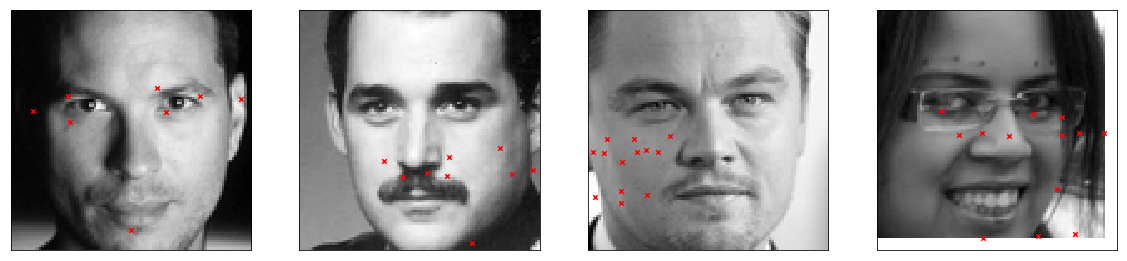

In [6]:
# function to show the images with bad labels for the facial keypoints
def plt_bad_data():
    # indices of the bad data(obtained by manual scan of the dataset)
    image_indices = [1747, 1877, 1907, 2199]
    
    # Read the train data from kaggle dataset
    X,y = get_orig_train_data()
    
    # Set the plot dimensions
    fig = plt.figure(figsize=(25,25))
    # Plot the bad images with facial keypoints
    for i in range(len(image_indices)):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        
        # Call function to plot the image and keypoints
        plot_image(X[image_indices[i]][0:1],y[image_indices[i]], ax)
        
    plt.show()

# Plot the train data images with bad labels for the facial keypoints
plt_bad_data()

#### Load the train data

In [6]:
# Load the pre-processed train data 
train_data, train_labels = load_dataset(test = False)
print("Train Images: " + str(train_data.shape) + " Train Labels: " + str(train_labels.shape))

Loading Data...
Train Images: (2138, 96, 96, 1) Train Labels: (2138, 30)


In [7]:
X_train, Y_train = train_data, train_labels
print("X_Train: " + str(X_train.shape) + " Y_Train: " + str(Y_train.shape))

X_Train: (2138, 96, 96, 1) Y_Train: (2138, 30)


In [8]:
# Load the pre-processed test data 
test_data, _ = load_dataset(test = True)
print("Test Images: " + str(test_data.shape))

Loading Data...
Test Images: (1783, 96, 96, 1)


## Data Augmentation

In [10]:
# Random image index for augmentation plotting
image_index = 51

### 1. Horizontal Flipping(Mirroring)


In [11]:
# Function to flip only the image horizontally
def flip_images(images):
    # Flip the image horizontally by inverting the pixels
    return images.reshape(-1,96,96)[:, :, list(range(95, -1, -1))].reshape(-1, 96*96)

# Function to flip the keypoint coordinates
# eg. left_eye_center_x with index 0 will be swapped with right_eye_center_x with index 2 
# Note: Only 'x' co-ordinates will be swapped. 'y' co-ordinate will be same as we are doing horizontal flip.
def flip_keypoints(keypoints, n_points):
    keypoints_flip = keypoints.copy()
    # x-coordinate flip is just 96-x. y-coordinate remains the same
    keypoints_flip[:, list(range(0, n_points-1, 2))] = 95 - keypoints[:, list(range(0, n_points-1, 2))]
    return keypoints_flip

In [12]:
# Call function to apply flipping on train data
X_train_flip = flip_images(X_train)
Y_train_flip = flip_keypoints(Y_train, 30)

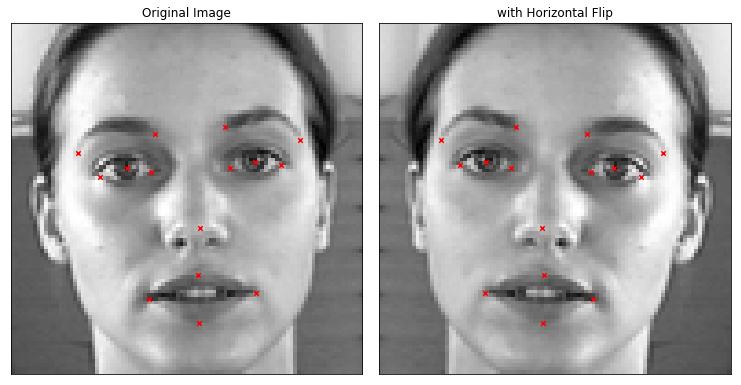

In [13]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train[image_index, range(0, 30, 2)], Y_train[image_index, range(1, 30, 2)], marker = 'x', s=20, color='r')

# Plot the flipped image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Horizontal Flip')
ax.imshow(X_train_flip[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train_flip[image_index, range(0, 30, 2)], Y_train_flip[image_index, range(1, 30, 2)], marker = 'x', s=20, color='r')

plt.show()

### 2. Rotation

In [14]:
# Based on the index of the image in the dataset, the direction of degree of rotation will be done.
# For even numbered indices, the images and keypoints will use +degree rotation.
# For odd numbered indices, the images and keypoints will use -degree rotation.
# This way the augmented dataset will have images rotated in both directions.

# Rotate images at given 'degree' angle
def rotate_images(images, degree):
    
    # create an array for rotated images
    rotated_images = np.zeros((images.shape), dtype=np.float32)
    
    # For each image rotate at angle of given degree 
    # Need to keep the limit between the pixel limits
    for i in range(rotated_images.shape[0]):
        if i%2 == 0:
            angle = degree
        else:
            angle = -degree
            
        rotated_images[i] = np.clip(rotate(images[i], angle, reshape=False, mode='constant', cval=150), 0, 1)  
    return rotated_images
        
    
# Rotate the facial keypoint coordinates at given degree angle
def rotate_keypoints(keypoints, degree, n_points):
    
    # create an array for rotated keypoint coordinates
    rotated_keypoints = np.zeros((keypoints.shape), dtype=np.float32)
    
    # define rotation angle and center of rotation
    #theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    # Loop through each keypoint and do rotation
    for i in range(rotated_keypoints.shape[0]):
        
        if i%2 == 0:
            theta = np.radians(degree)
        else:
            theta = np.radians(-degree)
            
        # obtain x and y coordinates from dataset
        x = keypoints[i][np.arange(0, n_points-1, 2)]
        y = keypoints[i][np.arange(1, n_points, 2)]

        # use rotation matrix to rotate coordinates around center
        new_x = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        new_y = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        rotated_keypoints[i] = np.vstack((new_x, new_y)).transpose().flatten()
        
    return rotated_keypoints

In [15]:
# Call functions to rotate image and keypoints at given degree
degree = 10
X_train_rotate = rotate_images(X_train, degree)
y_train_rotate = rotate_keypoints(Y_train, degree, 30)

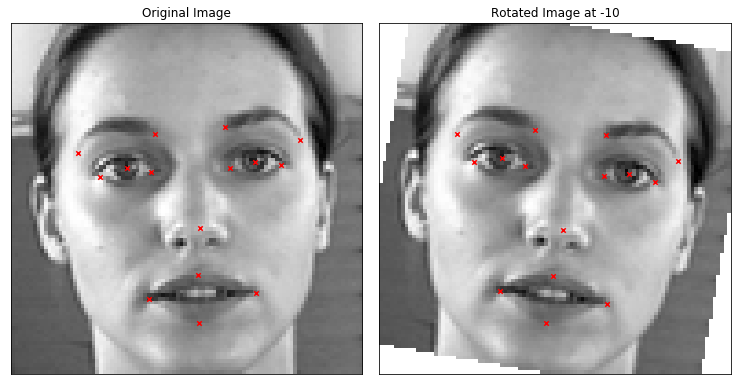

In [21]:
# Plot the results

# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train[image_index, range(0, 30, 2)], Y_train[image_index, range(1, 30, 2)], \
           marker = 'x', s=20, color='r')

# Plot the rotated image with labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
if image_index%2 ==0:
    degree_dir = '+' + str(degree)
else:
    degree_dir = '-' + str(degree)
    
ax.set_title('Rotated Image at '+ degree_dir)
ax.imshow(X_train_rotate[image_index].reshape(96,96),cmap='gray')
ax.scatter(y_train_rotate[image_index, range(0, 30, 2)], y_train_rotate[image_index, range(1, 30, 2)], \
           marker = 'x', s=20, color='r')



### 3. Histogram Equalization

This method increases the global contrast of most images mainly when the pixels in image represent close contrast values. It allows the intensities to be better distributed on histogram. It allows lower local contrast to gain a higher contrast.

https://medium.com/@animeshsk3/back-to-basics-part-1-histogram-equalization-in-image-processing-f607f33c5d55

In [20]:
# Make a copy of the training dataset to apply transformation
X_hist_eq = X_train.copy()

# Apply Histogram Equalization to the images
def image_histogram_eq(X_input):
    orig_images = X_input.reshape(96, 96)
    hist_eq_images = exposure.equalize_hist(orig_images)
    
    return hist_eq_images

# Apply histogram equalization on original train data
for index in range(0, len(X_train)):
    X_hist_eq[index] = image_histogram_eq(X_train[index]).reshape(96,96, 1)

# skimage is not able to impirt exposure on EC2. 

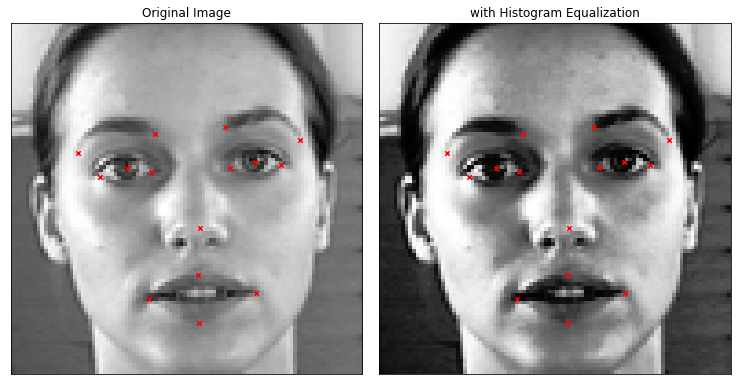

In [21]:
# Set the plot dimensions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train[image_index, range(0, 30, 2)], Y_train[image_index, range(1, 30, 2)], \
           marker = 'x', s=20, color='r')

# Plot the transformed image with train labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('with Histogram Equalization')
ax.imshow(X_hist_eq[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train[image_index, range(0, 30, 2)], Y_train[image_index, range(1, 30, 2)], \
           marker = 'x', s=20, color='r')
    
plt.show()

### 4. Blurring

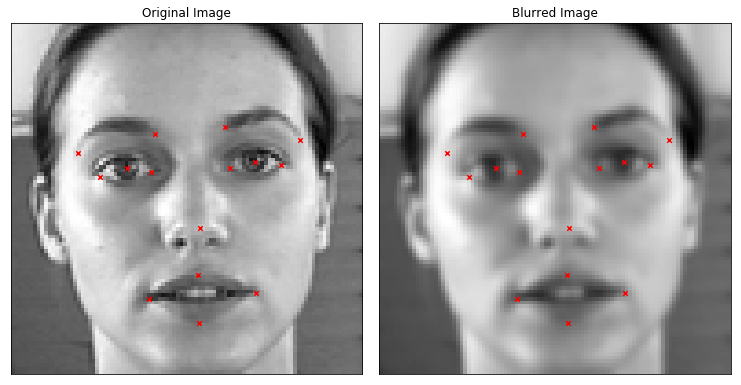

In [16]:
# Apply Blurring using Gaussian Filter to the train data images
    
# Make a copy of the training dataset to apply transformation
X_blur = X_train.copy()
    
# Apply Gaussian Blur to all the training data images
for index in range(0, len(X_train)):
    X_blur[index] = gaussian_filter(X_blur[index], sigma = 1).reshape(96, 96, 1)
        
# Set the plot dimensions
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
        
# Plot the original image with labels
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('Original Image')
ax.imshow(X_train[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train[image_index, range(0, 30, 2)], Y_train[image_index, range(1, 30, 2)], \
             marker = 'x', s=20, color='r')

# Plot the transformed image with train labels
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('Blurred Image')
ax.imshow(X_blur[image_index].reshape(96,96),cmap='gray')
ax.scatter(Y_train[image_index, range(0, 30, 2)], Y_train[image_index, range(1, 30, 2)], \
        marker = 'x', s=20, color='r')
    


### Defining the Datasets for Modeling

Based on the analysis of the given Kaggle training dataset done in the Baseline submission of the project, we found that out of the 30 keypoint labels, only 8 keypoints had data for more than 7000 images. 
The remaining 22 keypoint labels are present for only less than 3000 images. 
This demarcation in the labeling inconsistensies lead us to defining our modeling dataset(s) with the following approches:

- <b>Approach #1</b>
    * First dataset will comprise of all the 8 keypoints present for 7000+ images. We will have one model trained on this dataset.
    * Second dataset will comprise of the remaining 22 keypoints present for less than 3000 images. Have a second model trained on this dataset. 
    * Do prediction on the Kaggle Test Data on both models. Combine the 2 sets of predictions to determine overall performance.

- <b>Approach #2</b>
    * First dataset will comprise of all the 8 keypoints present for 7000+ images. We will have one model trained on this dataset.
    * Second dataset will comprise of the 30 keypoints present for around 2000 images. Have a second model trained on this dataset. 
    * Do prediction on the Kaggle Test Dataon both models. From the prediction from second model, replace predictions of the for the 8 keypoints(used in first model) with the corresponding predictions from first model. 
    
We feel either approach would not result in a much difference, so we decided to go with Approach #1.

Next we will define the 2 datasets and use these for testing data augmentation techniques with a simple model.

In [9]:
# Load given train data without pre-processing
#train_data_orig = pd.read_csv("../data/training/training.csv")
train_data_orig = pd.read_csv(FTRAIN)

In [18]:
# Check count of missing data fpr all 15 facial keypoints
train_data_orig.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

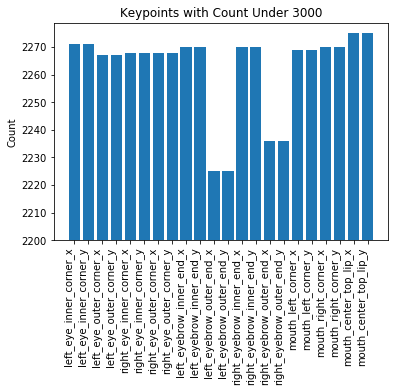

In [20]:
# keypoints with less than 3000 labels
kp = train_data_orig.describe()
less_kp = kp.loc[:, kp.loc['count'] < 3000].loc['count']
more_kp = kp.loc[:, kp.loc['count'] > 3000].loc['count']
_l = np.arange(len(less_kp))
_m = np.arange(len(more_kp))

fig, ax1 = plt.subplots()
ax1.bar(_l, less_kp-2200, bottom=2200)
ax1.set_ylabel('Count')
ax1.set_xticks(_l)
ax1.set_xticklabels(less_kp.index, rotation=90, ha='right')
ax1.set_title("Keypoints with Count Under 3000")
plt.show()

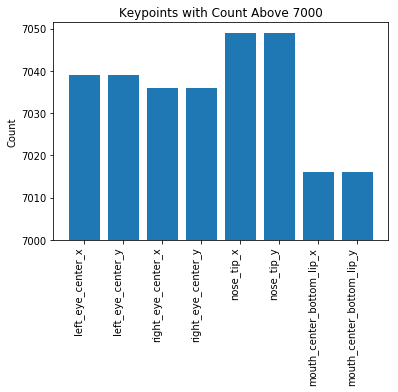

In [21]:
# Keypoints with more than 7000 labels
fig, ax2 = plt.subplots()
ax2.bar(_m, more_kp-7000, bottom=7000)
ax2.set_xticks(_m)
ax2.set_xticklabels(more_kp.index, rotation=90, ha='right')
ax2.set_ylabel('Count')
ax2.set_title("Keypoints with Count Above 7000")
plt.show()

In [22]:
# List the train data columns with corresponding indices in the dataset
for col in range(len(train_data_orig.columns)):
    print (col, train_data_orig.columns[col])

0 left_eye_center_x
1 left_eye_center_y
2 right_eye_center_x
3 right_eye_center_y
4 left_eye_inner_corner_x
5 left_eye_inner_corner_y
6 left_eye_outer_corner_x
7 left_eye_outer_corner_y
8 right_eye_inner_corner_x
9 right_eye_inner_corner_y
10 right_eye_outer_corner_x
11 right_eye_outer_corner_y
12 left_eyebrow_inner_end_x
13 left_eyebrow_inner_end_y
14 left_eyebrow_outer_end_x
15 left_eyebrow_outer_end_y
16 right_eyebrow_inner_end_x
17 right_eyebrow_inner_end_y
18 right_eyebrow_outer_end_x
19 right_eyebrow_outer_end_y
20 nose_tip_x
21 nose_tip_y
22 mouth_left_corner_x
23 mouth_left_corner_y
24 mouth_right_corner_x
25 mouth_right_corner_y
26 mouth_center_top_lip_x
27 mouth_center_top_lip_y
28 mouth_center_bottom_lip_x
29 mouth_center_bottom_lip_y
30 Image


#### Dataset #1
* left_eye_center
* right_eye_center
* node_tip
* mouth_center_bottom_lip

We will have 7000 images with 8 keypoint labels as shown below after trimming out missing data.

In [10]:
# Define the label indices for Dataset #1
d1_label_indices = [0, 1, 2, 3, 20, 21, 28, 29]
d1 = train_data_orig.iloc[:, d1_label_indices]
print(d1.shape)

# trim any missing data
d1_trim = d1[~np.isnan(d1).any(axis = 1)]
print("After trimming missing data: {}".format(d1_trim.shape))

(7049, 8)
After trimming missing data: (7000, 8)


#### Dataset #2
* left_eye_inner_corner
* left_eye_outer_corner
* right_eye_inner_corner
* right_eye_outer_corner
* left_eyebrow_inner_end
* left_eyebrow_outer_end
* right_eyebrow_inner_end
* right_eyebrow_outer_end
* mouth_left_corner
* mouth_right_corner
* mouth_center_top_lip

We will have 2155 images with 22 keypoint labels as shown below after trimming out missing data.

In [11]:
d2_label_indices = list(range(4, 20)) + list(range(22, 28))
d2 = train_data_orig.iloc[:, d2_label_indices]
print(d2.shape)

# trim any missing values
d2_trim = d2[~np.isnan(d2).any(axis = 1)]
print("After trimming missing data: {}".format(d2_trim.shape))


(7049, 22)
After trimming missing data: (2155, 22)


## Defining the 2 Datasets

#### Define Master Dataset

In [12]:
# Now split the Kaggle training dataset into input images and keypoints labels

# First shuffle the Kaggle training data
np.random.seed(533)
shuffle = np.random.permutation(np.arange(train_data_orig.shape[0]))
train_shuff = train_data_orig.iloc[shuffle].reset_index(drop=True)

print("Loading data...")
# Split out image values
images = []
for i in range(train_shuff.shape[0]):
    img = train_shuff['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    images.append(img) 

# Assign to np array
X_train_orig = np.array(images, dtype = 'float32')
print(X_train_orig.shape)

# Get the keypoint labels
labels = train_shuff.drop('Image', axis = 1)
Y_train_orig = np.array(labels, dtype = 'float32')
print(Y_train_orig.shape)

Loading data...
(7049, 9216)
(7049, 30)


In [ ]:
# Also save these arrays to use in other notebooks and across users
np.save('X_train_orig.npy', X_train)
np.save('Y_train_orig.npy', Y_train)

#### Dataset 1: 8 keypoints

We will have 7000 samples in this dataset.

In [13]:
# Dataset 1

# Filter the master dataset based on labels for only 8 keypoints as defined above
keypoints = [0, 1, 2, 3, 20, 21, 28, 29]
Y_train_d1 = Y_train_orig[:, keypoints]

# Remove missing labels
# Get list of non-missing labels
index_list = ~np.isnan(Y_train_d1).any(axis=1)

# Now define the final input images and keypoint labels for Dataset1
X_train_d1 = X_train_orig[index_list]
Y_train_d1 = Y_train_d1[index_list]

print(X_train_d1.shape)
print(Y_train_d1.shape)


(7000, 9216)
(7000, 8)


#### Dataset 2: 22 keypoints

We will have 2155 samples in this dataset.

In [14]:
# Filter the master dataset based on labels for only 22 keypoints as defined above
keypoints = list(range(4, 20)) + list(range(22, 28))
Y_train_d2 = Y_train_orig[:, keypoints]

# Remove missing labels
# Get list of non-missing labels
index_list = ~np.isnan(Y_train_d2).any(axis=1)

# Now define the final input images and keypoint labels for Dataset1
X_train_d2 = X_train_orig[index_list]
Y_train_d2 = Y_train_d2[index_list]

print(X_train_d2.shape)
print(Y_train_d2.shape)

(2155, 9216)
(2155, 22)


## Architecture Testing

In this section varipus classical and poular CNN architectures are used as inspiration to build our own simpler alternatives. The new models will use the split datasets for training. So we build 2 models for d1 and d2. 

In [15]:
# Helper function to find RMSE(Root Mean Squared Error)
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# The early stop callback will terminate a training session if no progress is being made
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=100, mode='auto')

# Reduce learning Rate on Plateau to reduce the learning rate once learning stagnates. 
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=30, min_lr=0.00001, patience = 4, verbose = 10)


#### 1. LeNet-5 with No Data Augmentation

Strting with the simplest, in the 1990s YannLeCun et al. came up with a neural network architure for handwritten and machine-printed character recognition. It consists of 2 sets of convolutional and average pooling layers followed by a flattening convolutional layer and then fully connected layers and a softmax classifier.

In [34]:
# Try to create a LeNet-5 based model using 'relu' activation 

# create model for dataset 1 - 8 keypoints
model_lenet = Sequential()
model_lenet.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model_lenet.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1), padding='valid'))
model_lenet.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model_lenet.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='valid'))
model_lenet.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model_lenet.add(Flatten())
model_lenet.add(Dense(120, activation='relu'))
model_lenet.add(Dense(84, activation='relu'))
model_lenet.add(Dense(8))

# compile model
model_lenet.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])

model_lenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 92, 92, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 91, 91, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 39, 39, 120)       48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 182520)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)              

In [35]:
# Train on Dataset 1
%time history_lenet_d1 = model_lenet.fit(X_train_d1.reshape(-1, 96, 96, 1), Y_train_d1, epochs=50, \
                                         shuffle=True, batch_size=10, validation_split = 0.2, \
                                         callbacks=[early_stop], verbose=2)

Train on 5600 samples, validate on 1400 samples
Epoch 1/50
 - 12s - loss: 882.8499 - rmse: 14.0320 - val_loss: 128.3535 - val_rmse: 11.0688
Epoch 2/50
 - 8s - loss: 118.8735 - rmse: 10.6480 - val_loss: 97.4353 - val_rmse: 9.6539
Epoch 3/50
 - 8s - loss: 99.4319 - rmse: 9.7334 - val_loss: 100.5454 - val_rmse: 9.8116
Epoch 4/50
 - 8s - loss: 77.7592 - rmse: 8.5475 - val_loss: 60.6493 - val_rmse: 7.6252
Epoch 5/50
 - 8s - loss: 21.9020 - rmse: 4.4293 - val_loss: 15.8550 - val_rmse: 3.5103
Epoch 6/50
 - 8s - loss: 9.0965 - rmse: 2.8433 - val_loss: 11.0209 - val_rmse: 3.0832
Epoch 7/50
 - 8s - loss: 6.2272 - rmse: 2.3381 - val_loss: 12.0685 - val_rmse: 3.1853
Epoch 8/50
 - 8s - loss: 4.8709 - rmse: 2.0811 - val_loss: 9.7922 - val_rmse: 2.8922
Epoch 9/50
 - 8s - loss: 3.7679 - rmse: 1.8250 - val_loss: 9.0760 - val_rmse: 2.8400
Epoch 10/50
 - 8s - loss: 3.3334 - rmse: 1.7242 - val_loss: 10.9613 - val_rmse: 3.1311
Epoch 11/50
 - 8s - loss: 3.4450 - rmse: 1.7294 - val_loss: 8.5365 - val_rmse: 2

In [36]:
model_lenet.save('model_lenet_k_d1.h5')

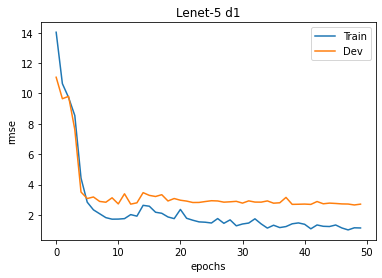

Val RMSE: 2.7131428718566895
Train RMSE: 1.1452465057373047 


In [37]:
# plot metrics
plt.plot(history_lenet_d1.history['rmse'], label = 'Train')
plt.plot(history_lenet_d1.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("rmse")
plt.title('Lenet-5 d1')
plt.show()

# look at final RMSE value after 10 epochs
print('Val RMSE: {}'.format(history_lenet_d1.history.get('val_rmse')[-1]))
print('Train RMSE: {} '.format(history_lenet_d1.history.get('rmse')[-1]))

In [38]:
# Try to create a LeNet-5 based model using 'relu' activation 

# create model for dataset 2: 22 keypoints 
model_lenet2 = Sequential()
model_lenet2.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(96,96,1), data_format='channels_last'))
model_lenet2.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1), padding='valid'))
model_lenet2.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model_lenet2.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='valid'))
model_lenet2.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model_lenet2.add(Flatten())
model_lenet2.add(Dense(120, activation='relu'))
model_lenet2.add(Dense(84, activation='relu'))
model_lenet2.add(Dense(22))

# compile model
model_lenet2.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])

model_lenet2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 92, 92, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 91, 91, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 87, 87, 16)        2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 39, 39, 120)       48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 182520)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)              

In [39]:
# Train on Dataset 2
%time history_lenet_d2 = model_lenet2.fit(X_train_d2.reshape(-1, 96, 96, 1), Y_train_d2, epochs=50, shuffle=True, \
                                          batch_size=10, validation_split = 0.2, \
                                          callbacks=[early_stop], verbose=2)


Train on 1724 samples, validate on 431 samples
Epoch 1/50
 - 3s - loss: 4172.3081 - rmse: 21.5249 - val_loss: 105.3251 - val_rmse: 10.0719
Epoch 2/50
 - 2s - loss: 105.0006 - rmse: 9.9843 - val_loss: 137.2525 - val_rmse: 11.6611
Epoch 3/50
 - 2s - loss: 82.5573 - rmse: 8.8796 - val_loss: 77.1152 - val_rmse: 8.5815
Epoch 4/50
 - 2s - loss: 63.7025 - rmse: 7.7905 - val_loss: 74.7579 - val_rmse: 8.4487
Epoch 5/50
 - 2s - loss: 54.3293 - rmse: 7.2114 - val_loss: 63.4408 - val_rmse: 7.8327
Epoch 6/50
 - 2s - loss: 49.2547 - rmse: 6.8741 - val_loss: 77.1493 - val_rmse: 8.4690
Epoch 7/50
 - 2s - loss: 42.8306 - rmse: 6.4100 - val_loss: 63.1480 - val_rmse: 7.6311
Epoch 8/50
 - 2s - loss: 38.5875 - rmse: 6.0141 - val_loss: 55.9641 - val_rmse: 7.2864
Epoch 9/50
 - 2s - loss: 29.8523 - rmse: 5.2973 - val_loss: 66.6842 - val_rmse: 8.0799
Epoch 10/50
 - 2s - loss: 27.5805 - rmse: 5.1031 - val_loss: 57.3633 - val_rmse: 7.4300
Epoch 11/50
 - 2s - loss: 25.3848 - rmse: 4.8900 - val_loss: 51.3880 - val

In [44]:
model_lenet2.save('model_lenet_k_d2.h5')

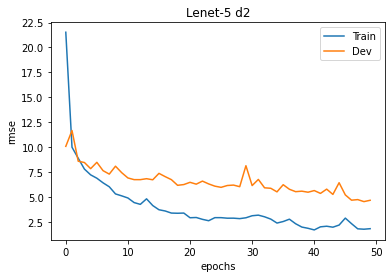

Val RMSE: 4.658419132232666
Train RMSE: 1.808635950088501 


In [41]:
# plot metrics
plt.plot(history_lenet_d2.history['rmse'], label = 'Train')
plt.plot(history_lenet_d2.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("rmse")
plt.title('Lenet-5 d2')
plt.show()

# look at final RMSE value after 10 epochs
print('Val RMSE: {}'.format(history_lenet_d2.history.get('val_rmse')[-1]))
print('Train RMSE: {} '.format(history_lenet_d2.history.get('rmse')[-1]))

In [ ]:
# Test Predictions
# Predict on 8 keypoints using model 1 
Y_test_d1 = test_predict(model_lenet, 'Lenet2_d1')
# Predict on 22 keypoints using model 2
Y_test_d2 = test_predict(model_lenet2, 'Lenet2_d2')

# Combine the predictions for all 30 keypoints
Y_test_combined = np.zeros((1783, 30), dtype = np.float32)
Y_test_combined[:, d1_label_indices] = Y_test_d1
Y_test_combined[:, d2_label_indices] = Y_test_d2

In [ ]:
# Call function to generate kaggle submission file for scoring
generate_submission(Y_test_combined, 'Lenet2_split_data')

We can see the model overfits on the train data and is not able to generalize on the vaidation set. 

#### 2. VGG-16 with smaller weights

Didn't test this model on Kaggle Kernel as it was taking the longest to run on EC2 with no good RMSE scores. 



In [ ]:
### VGG with smaller filters
def VGG_16(points):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='linear'))
    model.add(Dense(points))

    return model

#### 3. VGG-16 with reduced convolution layers

Uses Batch Normazation for regularization.

In [42]:
### VGG with reduced convolution layers

# Function to define the model.
# points -> indices of the keypoints to predict. 8 for dataset 1 and 22 for dataset 2
def VGG_16_2(points):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(96,96,1), data_format='channels_last'))
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(728, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(1024, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='linear'))
    model.add(Dropout(0.5))
    model.add(Dense(points))

    return model

In [43]:
# Create model using dataset 1 - 8 keypoints 
model_vgg_2_d1 = VGG_16_2(8)
model_vgg_2_d1.summary()


model_vgg_2_d1.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse])

# fit model
%time history_vgg_2_d1 = model_vgg_2_d1.fit(X_train_d1.reshape(-1, 96, 96, 1), Y_train_d1, epochs=50, \
                                 shuffle=True, batch_size=10, \
                                 validation_split = 0.2, \
                                 callbacks=[early_stop], verbose=2)

Train on 5600 samples, validate on 1400 samples
Epoch 1/50
 - 28s - loss: 166.9945 - rmse: 12.0313 - val_loss: 25.3003 - val_rmse: 4.9294
Epoch 2/50
 - 26s - loss: 38.4843 - rmse: 6.0943 - val_loss: 21.7709 - val_rmse: 4.5260
Epoch 3/50
 - 26s - loss: 25.3237 - rmse: 4.9316 - val_loss: 22.1134 - val_rmse: 4.1316
Epoch 4/50
 - 26s - loss: 19.8088 - rmse: 4.3323 - val_loss: 17.1044 - val_rmse: 3.9552
Epoch 5/50
 - 26s - loss: 18.9195 - rmse: 4.2311 - val_loss: 12.6039 - val_rmse: 3.3159
Epoch 6/50
 - 26s - loss: 18.6053 - rmse: 4.1828 - val_loss: 12.4173 - val_rmse: 3.4238
Epoch 7/50
 - 26s - loss: 17.6603 - rmse: 4.0742 - val_loss: 19.8814 - val_rmse: 4.3794
Epoch 8/50
 - 26s - loss: 14.7600 - rmse: 3.7222 - val_loss: 17.4064 - val_rmse: 4.1028
Epoch 9/50
 - 26s - loss: 16.8255 - rmse: 3.9514 - val_loss: 95.4575 - val_rmse: 6.5571
Epoch 10/50
 - 26s - loss: 15.4507 - rmse: 3.8098 - val_loss: 11.8645 - val_rmse: 3.2077
Epoch 11/50
 - 26s - loss: 14.0709 - rmse: 3.6309 - val_loss: 23.0372

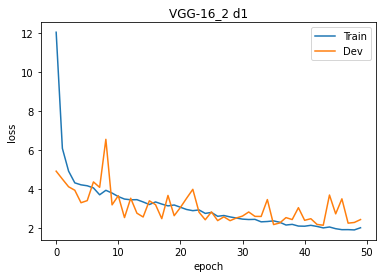

Val RMSE: 2.45601487159729
Train RMSE: 2.036926746368408 


In [45]:
# plot metrics
plt.plot(history_vgg_2_d1.history['rmse'], label = 'Train')
plt.plot(history_vgg_2_d1.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('VGG-16_2 d1')
plt.show()

# look at final RMSE value after 10 epochs
print('Val RMSE: {}'.format(history_vgg_2_d1.history.get('val_rmse')[-1]))
print('Train RMSE: {} '.format(history_vgg_2_d1.history.get('rmse')[-1]))

In [46]:
model_vgg_2_d1.save('model_vgg_2_k_d1.h5')

In [48]:
# Create model using dataset 2 - 22 keypoints 
model_vgg_2_d2 = VGG_16_2(22)

model_vgg_2_d2.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [rmse])

# fit model
%time history_vgg_2_d2 = model_vgg_2_d2.fit(X_train_d2.reshape(-1, 96, 96, 1), Y_train_d2, epochs=50, \
                                 shuffle=True, batch_size=10, \
                                 validation_split = 0.2, \
                                 callbacks=[early_stop], verbose=2)

Train on 1724 samples, validate on 431 samples
Epoch 1/50
 - 10s - loss: 205.0490 - rmse: 13.6994 - val_loss: 1438.5292 - val_rmse: 38.0099
Epoch 2/50
 - 8s - loss: 108.9667 - rmse: 10.3104 - val_loss: 1057.1556 - val_rmse: 32.3868
Epoch 3/50
 - 8s - loss: 63.1757 - rmse: 7.7961 - val_loss: 59.9904 - val_rmse: 7.6308
Epoch 4/50
 - 8s - loss: 43.1888 - rmse: 6.5012 - val_loss: 21.4553 - val_rmse: 4.6021
Epoch 5/50
 - 8s - loss: 29.7044 - rmse: 5.3602 - val_loss: 21.8504 - val_rmse: 4.6973
Epoch 6/50
 - 8s - loss: 21.9338 - rmse: 4.6195 - val_loss: 11.3547 - val_rmse: 3.3616
Epoch 7/50
 - 8s - loss: 18.4837 - rmse: 4.2518 - val_loss: 8.7448 - val_rmse: 2.9365
Epoch 8/50
 - 8s - loss: 16.1401 - rmse: 3.9662 - val_loss: 7.5985 - val_rmse: 2.7297
Epoch 9/50
 - 8s - loss: 13.8030 - rmse: 3.6620 - val_loss: 7.4912 - val_rmse: 2.6881
Epoch 10/50
 - 8s - loss: 13.6858 - rmse: 3.6625 - val_loss: 5.1255 - val_rmse: 2.2404
Epoch 11/50
 - 8s - loss: 13.9677 - rmse: 3.6816 - val_loss: 7.4464 - val_r

In [49]:
model_vgg_2_d2.save('model_vgg_2_k_d2.h5')

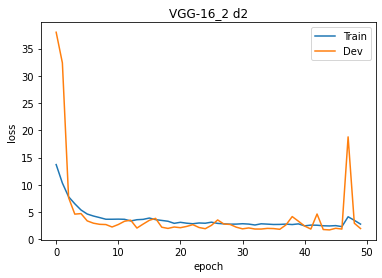

Val RMSE: 1.9564896821975708
Train RMSE: 2.767425775527954 


In [50]:
# plot metrics
plt.plot(history_vgg_2_d2.history['rmse'], label = 'Train')
plt.plot(history_vgg_2_d2.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('VGG-16_2 d2')
plt.show()

# look at final RMSE value after 10 epochs
print('Val RMSE: {}'.format(history_vgg_2_d2.history.get('val_rmse')[-1]))
print('Train RMSE: {} '.format(history_vgg_2_d2.history.get('rmse')[-1]))

In [51]:
# Using the 2 trained models predict on Test data
Y_test_vgg_2_d1 = test_predict(model_vgg_2_d1, 'vgg_2_d1')
Y_test_vgg_2_d2 = test_predict(model_vgg_2_d2, 'vgg_2_d2')

# Combine both results
Y_test_vgg_2_combined = np.zeros((1783, 30), dtype = np.float32)
Y_test_vgg_2_combined[:, d1_label_indices] = Y_test_vgg_2_d1
Y_test_vgg_2_combined[:, d2_label_indices] = Y_test_vgg_2_d2

In [52]:
# Call function to generate kaggle submission file for scoring   
generate_submission(Y_test_vgg_2_combined, 'vgg16_2_split_data')

(27124, 2)


In [40]:
# Let's try to see a random prediction 
image = []
for i in range(test.shape[0]):
    img = test['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    image.append(img)
    
# Reshape for prediction
X_test = np.array(image, dtype = 'float').reshape(-1,96,96,1)
X_test.shape

(1783, 96, 96, 1)

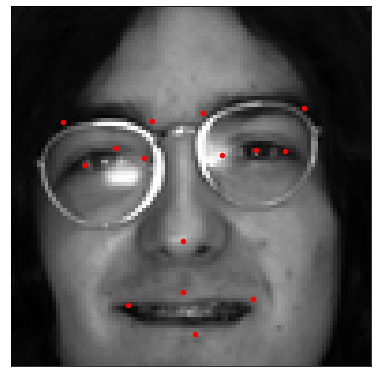

In [78]:
# Plot
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
image_idx = 350
img = X_test[image_idx].reshape(96, 96)
ax.imshow(img, cmap='gray')
ax.scatter(Y_test_vgg_2_combined[image_idx].reshape(30,)[range(0,30,2)], Y_test_vgg_2_combined[image_idx].reshape(30,)[range(1,30,2)], marker='o', s = 20, color='r')
plt.show()

### 4. AlexNet 

In [17]:
# Function to define the model.
# points -> indices of the keypoints to predict. 8 for dataset 1 and 22 for dataset 2
def AlexNet2(points):
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(96, 96, 1), data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    model.add(Conv2D(384, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2000, activation='linear'))
    model.add(Dense(points))
    

    return model



In [18]:
# Create model using dataset 1 - 8 keypoints 
model_alexnet_d1 = AlexNet2(points=8)
model_alexnet_d1.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model
%time history_alexnet_d1 = model_alexnet_d1.fit(X_train_d1.reshape(-1, 96, 96, 1), Y_train_d1, epochs=50, \
                                                shuffle=True, batch_size=10, \
                                                validation_split = 0.2, \
                                                callbacks=[early_stop], verbose=2)

Train on 5600 samples, validate on 1400 samples
Epoch 1/50
 - 17s - loss: 9.6675 - rmse: 9.6676 - val_loss: 4.3704 - val_rmse: 4.3704
Epoch 2/50
 - 15s - loss: 4.6085 - rmse: 4.6085 - val_loss: 4.3130 - val_rmse: 4.3130
Epoch 3/50
 - 15s - loss: 4.5585 - rmse: 4.5585 - val_loss: 4.0857 - val_rmse: 4.0857
Epoch 4/50
 - 15s - loss: 4.5321 - rmse: 4.5321 - val_loss: 4.3305 - val_rmse: 4.3305
Epoch 5/50
 - 15s - loss: 4.5210 - rmse: 4.5210 - val_loss: 4.2160 - val_rmse: 4.2160
Epoch 6/50
 - 15s - loss: 4.5028 - rmse: 4.5028 - val_loss: 4.0265 - val_rmse: 4.0265
Epoch 7/50
 - 15s - loss: 4.4525 - rmse: 4.4525 - val_loss: 4.0493 - val_rmse: 4.0493
Epoch 8/50
 - 15s - loss: 4.4540 - rmse: 4.4540 - val_loss: 4.0219 - val_rmse: 4.0219
Epoch 9/50
 - 15s - loss: 4.4001 - rmse: 4.4001 - val_loss: 4.1569 - val_rmse: 4.1569
Epoch 10/50
 - 15s - loss: 4.4100 - rmse: 4.4100 - val_loss: 4.3773 - val_rmse: 4.3773
Epoch 11/50
 - 15s - loss: 4.3891 - rmse: 4.3891 - val_loss: 4.3526 - val_rmse: 4.3526
Epoc

In [ ]:
model_alexnet_d1.save('model_alexnet_k_d1.h5')

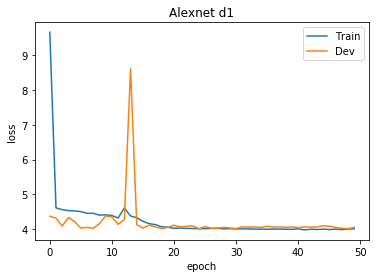

Val RMSE: 4.050360679626465
Train RMSE: 4.005143165588379 


In [19]:
# plot metrics
plt.plot(history_alexnet_d1.history['rmse'], label = 'Train')
plt.plot(history_alexnet_d1.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Alexnet d1')
plt.show()

# look at final RMSE value after 50 epochs
print('Val RMSE: {}'.format(history_alexnet_d1.history.get('val_rmse')[-1]))
print('Train RMSE: {} '.format(history_alexnet_d1.history.get('rmse')[-1]))

In [20]:
# Create model using dataset 2 - 22 keypoints 
model_alexnet_d2 = AlexNet2(points=22)
model_alexnet_d2.compile(loss=rmse, optimizer='adam', metrics=[rmse])

# fit model
%time history_alexnet_d2 = model_alexnet_d2.fit(X_train_d2.reshape(-1, 96, 96, 1), Y_train_d2, epochs=50, \
                                                shuffle=True, batch_size=10, \
                                                validation_split = 0.2, \
                                                callbacks=[early_stop], verbose=2)

Train on 1724 samples, validate on 431 samples
Epoch 1/50
 - 5s - loss: 19.0943 - rmse: 19.0766 - val_loss: 8.0027 - val_rmse: 8.0228
Epoch 2/50
 - 5s - loss: 6.4240 - rmse: 6.4170 - val_loss: 4.0390 - val_rmse: 4.0431
Epoch 3/50
 - 5s - loss: 4.1986 - rmse: 4.2036 - val_loss: 3.1297 - val_rmse: 3.1405
Epoch 4/50
 - 5s - loss: 3.8829 - rmse: 3.8872 - val_loss: 3.3510 - val_rmse: 3.3874
Epoch 5/50
 - 5s - loss: 3.8231 - rmse: 3.8257 - val_loss: 3.3937 - val_rmse: 3.3870
Epoch 6/50
 - 5s - loss: 3.7875 - rmse: 3.7843 - val_loss: 3.2156 - val_rmse: 3.2222
Epoch 7/50
 - 5s - loss: 3.7254 - rmse: 3.7224 - val_loss: 3.0488 - val_rmse: 3.0724
Epoch 8/50
 - 5s - loss: 3.7142 - rmse: 3.7142 - val_loss: 3.2594 - val_rmse: 3.2669
Epoch 9/50
 - 5s - loss: 3.7108 - rmse: 3.7182 - val_loss: 3.1293 - val_rmse: 3.1444
Epoch 10/50
 - 5s - loss: 3.6248 - rmse: 3.6279 - val_loss: 2.8920 - val_rmse: 2.8785
Epoch 11/50
 - 5s - loss: 3.5980 - rmse: 3.5962 - val_loss: 3.1393 - val_rmse: 3.1446
Epoch 12/50
 -

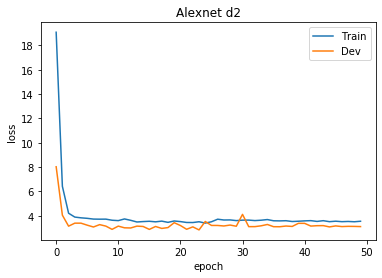

Val RMSE: 3.1064062118530273
Train RMSE: 3.544613838195801 


In [21]:
# plot metrics
plt.plot(history_alexnet_d2.history['rmse'], label = 'Train')
plt.plot(history_alexnet_d2.history['val_rmse'], label = 'Dev')
plt.legend(loc="best")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Alexnet d2')
plt.show()

# look at final RMSE value after 50 epochs
print('Val RMSE: {}'.format(history_alexnet_d2.history.get('val_rmse')[-1]))
print('Train RMSE: {} '.format(history_alexnet_d2.history.get('rmse')[-1]))

In [ ]:
model_alexnet_d2.save('model_alexnet_k_d2.h5')

In [37]:
# Load the saved model weights. Unfortunately Keras doesn't store the history by default.
model_alexnet_d1 = load_model('model_alexnet_k_d1.h5', custom_objects=None, compile=False)
model_alexnet_d2 = load_model('model_alexnet_k_d2.h5', custom_objects=None, compile=False)

In [22]:
# Using the 2 trained models predict on Test data
Y_test_alex_d1 = test_predict(model_alexnet_d1, 'alex_d1')
Y_test_alex_d2 = test_predict(model_alexnet_d2, 'alex_d2')

# Combine the predictions for all 30 keypoints    
Y_test_alex_combined = np.zeros((1783, 30), dtype = np.float32)
Y_test_alex_combined[:, d1_label_indices] = Y_test_alex_d1
Y_test_alex_combined[:, d2_label_indices] = Y_test_alex_d2

In [ ]:
# Call function to generate kaggle submission file for scoring  
generate_submission(Y_test_alex_combined, 'alex_split_data')

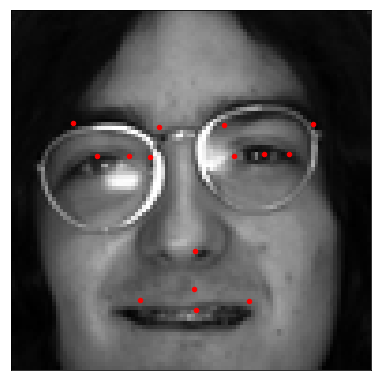

In [41]:
# Plot
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
image_idx = 350
img = X_test[image_idx].reshape(96, 96)
ax.imshow(img, cmap='gray')
ax.scatter(Y_test_alex_combined[image_idx].reshape(30,)[range(0,30,2)], Y_test_alex_combined[image_idx].reshape(30,)[range(1,30,2)], marker='o', s = 20, color='r')
plt.show()